# 적대적 예제 생성

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
 
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

## 구현

In [3]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "data/lenet_mnist_model.pth"
use_cuda = True
torch.manual_seed(42)

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            ])),
        batch_size=1, shuffle=True)

print("CUDA Available:", torch.cuda.is_available())
device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")

model = Net().to(device)

model.load_state_dict(torch.load(pretrained_model, map_location=device))

model.eval()

CUDA Available: True


/tmp/ipykernel_22515/4263937746.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pretrained_model, map_location=device))


FileNotFoundError: [Errno 2] No such file or directory: 'data/lenet_mnist_model.pth'

In [8]:
# FGSM 공격 코드
def fgsm_attack(image, epsilon, data_grad):
    # data_grad 의 요소별 부호 값을 얻어옵니다
    sign_data_grad = data_grad.sign()
    # 입력 이미지의 각 픽셀에 sign_data_grad 를 적용해 작은 변화가 적용된 이미지를 생성합니다
    perturbed_image = image + epsilon*sign_data_grad
    # 값 범위를 [0,1]로 유지하기 위해 자르기(clipping)를 추가합니다
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # 작은 변화가 적용된 이미지를 리턴합니다
    return perturbed_image

# 텐서를 원래 스케일로 복원
def denorm(batch, mean=[0.1307], std=[0.3081]):
    """
    텐서 묶음(batch)을 원래 스케일로 변환합니다.
    Args:
        batch (torch.Tensor): 정규화된 텐서 배치(batch)
        mean (torch.Tensor or list): 정규화시 사용했던 평균(mean)
        std (torch.Tensor or list): 정규화시 사용했던 표준편차(standard deviation)
    Returns:
        torch.Tensor: 정규화가 적용되지 않은 텐서 묶음(batch)
    """
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(device)
    if isinstance(std, list):
        std = torch.tensor(std).to(device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

In [9]:
def test( model, device, test_loader, epsilon ):

    # 정확도 카운터
    correct = 0
    adv_examples = []

    # 테스트 셋의 모든 예제에 대해 루프를 돕니다
    for data, target in test_loader:

        # 디바이스(CPU or GPU) 에 데이터와 라벨 값을 보냅니다
        data, target = data.to(device), target.to(device)

        # 텐서의 속성 중 requires_grad 를 설정합니다. 공격에서 중요한 부분입니다
        data.requires_grad = True

        # 데이터를 모델에 통과시킵니다
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # 로그 확률의 최대값을 가지는 인덱스를 얻습니다

        # 만약 초기 예측이 틀리면, 공격하지 않도록 하고 계속 진행합니다
        if init_pred.item() != target.item():
            continue

        # 손실을 계산합니다
        loss = F.nll_loss(output, target)

        # 모델의 변화도들을 전부 0으로 설정합니다
        model.zero_grad()

        # 후방 전달을 통해 모델의 변화도를 계산합니다
        loss.backward()

        # 변화도 값을 모읍니다
        data_grad = data.grad.data

        # 데이터를 원래 스케일로 복원합니다
        data_denorm = denorm(data)

        # FGSM 공격을 호출합니다
        perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)

        # 정규화를 다시 적용합니다
        perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)

        # 작은 변화가 적용된 이미지에 대해 재분류합니다
        output = model(perturbed_data_normalized)

        # 올바른지 확인합니다
        final_pred = output.max(1, keepdim=True)[1] # 로그 확률의 최대값을 가지는 인덱스를 얻습니다
        if final_pred.item() == target.item():
            correct += 1
            # 0 엡실론 예제에 대해서 저장합니다
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # 추후 시각화를 위하 다른 예제들을 저장합니다
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # 해당 엡실론에서의 최종 정확도를 계산합니다
    final_acc = correct/float(len(test_loader))
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(test_loader)} = {final_acc}")

    # 정확도와 적대적 예제를 리턴합니다
    return final_acc, adv_examples

In [10]:
accuracies = []
examples = []

for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 227 / 10000 = 0.0227
Epsilon: 0.05	Test Accuracy = 171 / 10000 = 0.0171
Epsilon: 0.1	Test Accuracy = 116 / 10000 = 0.0116
Epsilon: 0.15	Test Accuracy = 99 / 10000 = 0.0099
Epsilon: 0.2	Test Accuracy = 73 / 10000 = 0.0073
Epsilon: 0.25	Test Accuracy = 70 / 10000 = 0.007
Epsilon: 0.3	Test Accuracy = 73 / 10000 = 0.0073


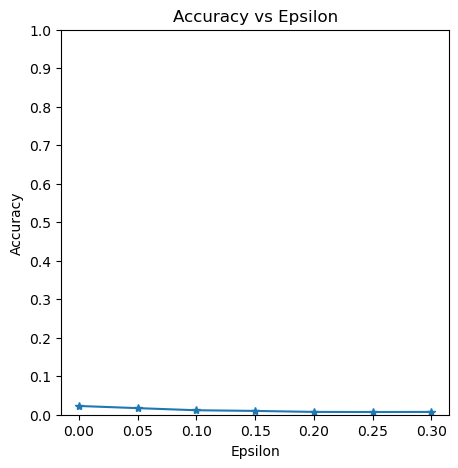

In [11]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

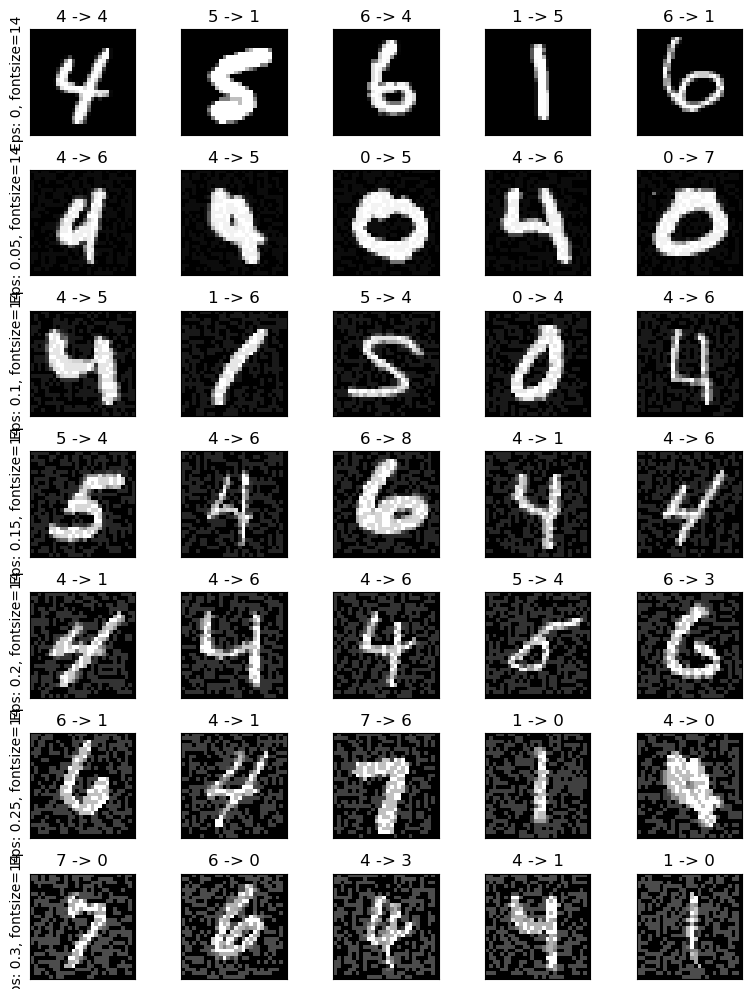

In [12]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons), len(examples[0]), cnt)
        plt.xticks([],[])
        plt.yticks([],[])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}, fontsize=14")
        orig,adv,ex = examples[i][j]
        plt.title(f"{orig} -> {adv}")
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()